In [1]:
import os
import sys
sys.path.append("../")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import jax
import jax.numpy as jnp
from jax import vmap, jit
import numpyro.distributions as dist
from einops import rearrange, repeat
from scipy.stats import multivariate_normal

%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pylab as pylab
import warnings
import matplotlib.cbook

from plot_params import params

warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

plt.rcParams.update({
  "text.usetex": True,
})

In [3]:
from gigalens.model import PhysicalModel
from gigalens.jax.simulator import LensSimulator
from gigalens.simulator import SimulatorConfig
from gigalens.jax.profiles.light import interp
from gigalens.jax.profiles.mass import shear, sie

In [4]:
# Color maps for main and residual plots
cmap = 'magma'
cmap_resid = 'RdGy'

## Configuration

In [5]:
data_dir = "../data/"

In [6]:
## Image configuration

image_extent = 5  # Size of image in arcmin
n_xy = 500  # Number of pixels

n_sup = 1  # Supersampling of source factor during fitting
n_xy_s = int(n_sup * n_xy)

fwhm_psf = 0.005  # ELT FWHM of 5 mas from 1903.04742

In [179]:
lens_conf_idx = 0

In [7]:
## MLP configuration

num_dense_layers = 4
dense_layer_width = 256
add_positional_encoding = False
positional_encoding_dims = 5
add_random_fourier = True
bandwidth_rff = 5.
add_skip_connection = False

In [8]:
## RNG; set to fixed values for deterministic run
key_model = 42  # np.random.randint(1000)
key_train = 43  # np.random.randint(1000)

In [9]:
## Training configuration

n_q_samples = 64  # Number of MC samples used to build ELBO expectation

learning_rate_init = 1e-3
learning_rate_variational = 1e-3
weight_decay = 1e-4
momentum = 0.5
optimizer_name = "adamw"

train_epochs = 15000
warmup_steps = 0
plot_every = 200

## Source image

In [10]:
from PIL import Image
from skimage.transform import resize
from urllib import request

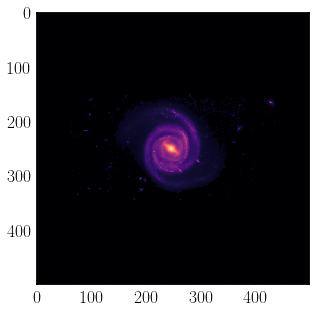

In [198]:
# galaxy_url = "https://cdn.spacetelescope.org/archives/images/large/potw2015a.jpg"
# galaxy_name = "NGC2906"

# galaxy_url = "https://cdn.spacetelescope.org/archives/images/large/opo0501a.jpg"
# galaxy_name = "NGC1300"

galaxy_url = "https://cdn.spacetelescope.org/archives/images/large/potw1801a.jpg"
galaxy_name = "UGC6093"


if not os.path.exists("{}/galaxy_images/{}.jpg".format(data_dir, galaxy_name)):
    request.urlretrieve(galaxy_url, "{}/galaxy_images/{}.jpg".format(data_dir, galaxy_name))

im_source = np.asarray(Image.open("{}/galaxy_images/{}.jpg".format(data_dir, galaxy_name)).convert('L'))

im_source_temp = np.zeros((np.max(im_source.shape), np.max(im_source.shape)))
im_source_temp[int(im_source.shape[1] / 2 - im_source.shape[0] / 2):int(im_source.shape[1] / 2 + im_source.shape[0] / 2), :] = im_source
im_source = im_source_temp
im_source = im_source - np.min(im_source)
im_source = im_source / np.max(im_source)
if galaxy_name == "NGC1300":
    im_source = np.pad(im_source, (1920, 1920))
elif galaxy_name == "UGC6093":
    im_source = np.pad(im_source, (640, 640))
else:
    im_source = np.pad(im_source, (1024, 1024))
im_source = resize(im_source, (n_xy_s, n_xy_s), anti_aliasing=True)
im_source[im_source < 0.05] = 0.
plt.imshow(im_source , cmap=cmap)


## Lensed image

In [199]:
sigma_psf = fwhm_psf / 2 ** 1.5 * np.sqrt(np.log(2))  # Convert FWHM to standard deviation

In [200]:
## Make Gaussian PSF kernel

delta_pix = image_extent / n_xy

x_kern = np.linspace(-6, 6, 13)
x, y = np.meshgrid(x_kern, x_kern)
kernel = multivariate_normal(mean=np.zeros(2), cov=np.ones(2) * sigma_psf / delta_pix).pdf(np.dstack((x, y)))
kernel /= np.sum(kernel)

# plt.imshow(kernel)

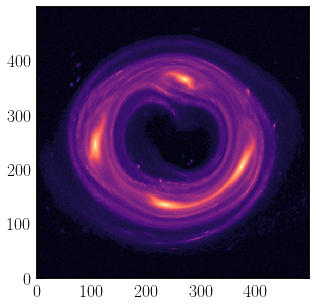

In [201]:
## Lensed image

# Supersample to reduce artifacting
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=n_xy_s, supersample=8, kernel=kernel)
coord_half = sim_config.delta_pix * sim_config.num_pix / 2
x_lims = [-coord_half, coord_half]
y_lims = [-coord_half, coord_half]
phys_model = PhysicalModel([sie.SIE(), shear.Shear()], [], [interp.Interp()])

lens_sim = LensSimulator(phys_model, sim_config, bs=1)

if lens_conf_idx == 0:
    truth = [[
        {'theta_E': 1.3, 'e1': 0.2, 'e2': 0.1, 'center_x': 0.1, 'center_y': 0.0},
        {'gamma1': -0.02, 'gamma2': 0.02}
    ], [ 
        {'img': im_source, 'x_lims': x_lims, 'y_lims': y_lims}
    ]]
elif lens_conf_idx == 1:
    truth = [[
        {'theta_E': 1.1, 'e1': 0.1, 'e2': 0.15, 'center_x': 0.4, 'center_y': -0.1},
        {'gamma1': -0.03, 'gamma2': 0.04}
    ], [ 
        {'img': im_source, 'x_lims': x_lims, 'y_lims': y_lims}
    ]]
else:
    raise NotImplementedError
    
std_noise = 1.e-6
image = lens_sim.simulate(truth)
image += std_noise * np.random.randn(*image.shape)
image = image.reshape(-1, n_sup, image.shape[-1] // n_sup, n_sup).sum((-1, -3))

# Revert supersampling configuration for forward simulator
sim_config = SimulatorConfig(delta_pix=delta_pix, num_pix=n_xy_s, supersample=1, kernel=kernel)
lens_sim = LensSimulator(phys_model, sim_config, bs=1)

plt.imshow(image.T, origin='lower' , cmap=cmap)

In [202]:
# Compute SNR around lens
np.median(image[image > 0.5 * image.max()] / std_noise)

64.05347

In [203]:
# Compute max SNR
image.max() / std_noise

DeviceArray(100.31958, dtype=float32)

## Lensed image rendering function wrapper

In [204]:
def render_lens(inputs):
    
    samples_src, samples_lens_params, x_lims, y_lims = inputs
    
    theta_E, theta_x, theta_y, e_1, e_2, gamma_1, gamma_2 = samples_lens_params
    
    truth = [[
        {'theta_E': theta_E, 'e1': e_1, 'e2': e_2, 'center_x': theta_x, 'center_y': theta_y},
        {'gamma1': gamma_1, 'gamma2': gamma_2}
    ], [ 
        {'img': samples_src, 'x_lims': x_lims, 'y_lims': y_lims}
    ]]

    image = lens_sim.simulate(truth)
    lens_sim.simulate(truth)
    
    return image

In [205]:
render_lens_vmapped = vmap(jit(render_lens))

## NeRF

In [206]:
from models.nerf import NeRFModel

import jax
import optax
import flax.linen as nn
from flax.training import train_state

In [207]:
def initialize_model(key, input_pts_shape):

    model = NeRFModel(num_dense_layers=num_dense_layers,
                      dense_layer_width=dense_layer_width,
                      add_positional_encoding=add_positional_encoding,
                      add_random_fourier=add_random_fourier,
                      add_skip_connection=add_skip_connection,
                      positional_encoding_dims=positional_encoding_dims,
                      bandwidth_rff=bandwidth_rff)

    # Initialize the model parameters
    initial_params = jax.jit(model.init)(
        {"params": key},
        jnp.ones(input_pts_shape),
    )
    
    return model, initial_params["params"]

In [208]:
theta_x_lims = theta_y_lims = x_lims
theta_x_coords, theta_y_coords = jnp.meshgrid(jnp.linspace(theta_x_lims[0], theta_x_lims[1], n_xy_s), jnp.linspace(theta_y_lims[0], theta_y_lims[1], n_xy_s))

coords = jnp.array([theta_x_coords, theta_y_coords])
image_input =  jnp.expand_dims(image, 0)

In [209]:
import functools

lct = dist.transforms.SoftplusLowerCholeskyTransform()

@functools.partial(jax.jit, static_argnums=3)
def train_step(state, batch, key, learning_rate_fn):
    """ Single train step
    """
    # Unravel the inputs and targets from the batch
    inputs, targets = batch
    inputs = rearrange(inputs, "c h w -> (h w) c")
    
    # jitter = jax.random.normal(key, shape=(2,)) * sim_config.delta_pix / 2.  # Add some jitter to the input coordinates
    jitter = jax.random.normal(key, shape=(2,)) * 0. # No jitter
    
    inputs = inputs + jitter[jnp.newaxis, :]
    
    key_lens, key_source = jax.random.split(key)
    
    # Compute the loss
    def loss_fn(params):

        model_fn = lambda x: state.apply_fn({"params": params}, x)
        model_output, loc, scale_tri = model_fn(inputs)
                        
        model_output = rearrange(model_output, "(h w) mus -> mus (h w)", h=n_xy_s, w=n_xy_s)
        
        ## Lens param loss
        
        # Lens variational distribution
        scale_tri = lct(scale_tri)
        dist_lens = dist.MultivariateNormal(loc=loc, scale_tril=scale_tri)
        
        # Lens prior
        dist_prior_lens_unif = dist.Uniform(low=jnp.array([1., -0.5, -0.5]), high=jnp.array([2., 0.5, 0.5]))
        dist_prior_lens_norm = dist.Normal(loc=jnp.array([0., 0., 0., 0.]), scale=jnp.array([0.3, 0.3, .05, 0.05]))
        
        # MC samples of lens parameters
        samples_lens = dist_lens.sample(key=key_lens, sample_shape=(n_q_samples,))
        
        
        loss_q_lens = jnp.sum(dist_lens.log_prob(samples_lens)) / n_q_samples                        
        loss_prior_lens = -jnp.sum(dist_prior_lens_unif.log_prob(samples_lens[:, :-4])) / n_q_samples \
                            -jnp.sum(dist_prior_lens_norm.log_prob(samples_lens[:, -4:])) / n_q_samples \

        ## Source param loss
        
        # Source variational distribution
        mu, sigma = nn.softplus(model_output[0]), nn.softplus(model_output[1])
        dist_source = dist.Normal(mu, sigma)  
        
        # Source prior
        dist_prior_source = dist.HalfNormal(scale=1. * jnp.ones_like(mu))
        
        # Source MC samples
        samples_source = dist_source.sample(key=key_source, sample_shape=(n_q_samples,))
        # samples_source = repeat(im_source, "h w -> s (h w)", s=n_q_samples)  # If testing with true source
        
        loss_q_source = jnp.sum(dist_source.log_prob(samples_source)) / n_q_samples
        loss_prior_source = -jnp.sum(dist_prior_source.log_prob(samples_source)) / n_q_samples
                
        samples_source = rearrange(samples_source, "s (h w) -> s h w", h=n_xy_s, w=n_xy_s)
        
        x_lims = repeat(jnp.array([-coord_half, coord_half]) + jitter[0], "xx -> nq xx", nq=n_q_samples)
        y_lims = repeat(jnp.array([-coord_half, coord_half]) + jitter[1], "yy -> nq yy", nq=n_q_samples)
        
        # Render lenses
        lenses = render_lens_vmapped((samples_source, samples_lens, x_lims, y_lims))
        lenses = lenses.reshape(lenses.shape[0], lenses.shape[-1] // n_sup, n_sup, lenses.shape[-1] // n_sup, n_sup).sum((-1, -3))
        
        # Compute log-probability
        loss_likelihood = -jnp.sum(dist.Normal(targets, std_noise).log_prob(lenses)) / n_q_samples
            
        # Return total loss
        return  loss_q_source + loss_prior_source + loss_q_lens + loss_prior_lens + loss_likelihood
    
    # Transform the loss function to get the loss value and the gradients
    train_loss, gradients = jax.value_and_grad(loss_fn)(state.params)
    
    # Updated state
    new_state = state.apply_gradients(grads=gradients)
    train_loss = jnp.mean(train_loss)
        
    return train_loss, new_state

In [210]:
lr_schedule = optax.warmup_cosine_decay_schedule(init_value=0, peak_value=learning_rate_init, warmup_steps=warmup_steps, decay_steps=train_epochs - warmup_steps)
lr_schedule_variational = optax.warmup_cosine_decay_schedule(init_value=0, peak_value=learning_rate_variational, warmup_steps=warmup_steps, decay_steps=train_epochs - warmup_steps)

In [211]:
def map_nested_fn(fn):
    '''Recursively apply `fn` to the key-value pairs of a nested dict'''
    def map_fn(nested_dict):
        return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v)) for k, v in nested_dict.items()}
    return map_fn

In [212]:
# Random Number Generator
key, rng = jax.random.split(jax.random.PRNGKey(key_model))

# Initialize the Model
model, params = initialize_model(key, (n_xy_s * n_xy_s, 2))

# Define the Optimizer
if optimizer_name == "adamw":
    optimizer = optax.adamw(learning_rate=lr_schedule, weight_decay=weight_decay)
elif optimizer_name == "sgdm":
    optimizer = optax.sgd(learning_rate=lr_schedule, momentum=momentum, nesterov=True)
else:
    raise NotImplementedError

optimizer_variational = optax.adabelief(learning_rate=lr_schedule_variational)

## Training state
label_fn = map_nested_fn(lambda k, _: "mlp" if k in ["w", "b"] else "var_params")
tx = optax.multi_transform({'mlp': optimizer, 'var_params': optimizer_variational}, label_fn)
params = params.unfreeze()
state = train_state.TrainState.create(apply_fn=model.apply, params=params, tx=tx)

# Train and validation loop
def train_and_eval(state, train_step_fn, learning_rate_fn):
        
    train_loss_history, reconstructed_src_mu_history, reconstructed_src_std_history, reconstructed_lens_history = [], [], [], []
    loc_history, scale_tri_history = [], []
    key, rng = jax.random.split(jax.random.PRNGKey(key_train))
    
    for epoch in tqdm(range(train_epochs)):
                
        train_batch = coords, image_input

        # Perform the Training Step
        key, rng = jax.random.split(key)
        train_loss, state = train_step_fn(state, train_batch, key, learning_rate_fn)
                      
        train_loss_history.append(np.asarray(np.mean(train_loss)))

        # Plot the result every plot interval
        if epoch % plot_every == 0:    
            
            model_fn = lambda x: state.apply_fn({"params": state.params}, x)
            model_output, loc, scale_tri = model_fn(rearrange(coords, "c h w -> (h w) c"))
            model_output = rearrange(model_output, "(h w) c -> c h w", h=n_xy_s, w=n_xy_s)
                        
            lenses = render_lens((nn.softplus(model_output[0]), loc, x_lims, y_lims))
            lenses = lenses.reshape(lenses.shape[-1] // n_sup, n_sup, lenses.shape[-1] // n_sup, n_sup).sum((-1, -3))

            reconstructed_lens_history.append(np.asarray(lenses.T))
            reconstructed_src_mu_history.append(np.asarray(nn.softplus(model_output[0])))
            reconstructed_src_std_history.append(np.asarray(nn.softplus(model_output[1])))
            
            loc_history.append(np.asarray(loc))
            scale_tri_history.append(np.asarray(scale_tri))
    
    hist = {
        "train_loss": train_loss_history,
        "reconstructed_lens": reconstructed_lens_history,
        "reconstructed_src_mu": reconstructed_src_mu_history,
        "reconstructed_src_std": reconstructed_src_std_history,
        "loc_history": loc_history,
        "scale_tri_history": scale_tri_history
    }
    
    return state, hist

In [213]:
state, hist = train_and_eval(state, train_step, lr_schedule)

100%|██████████| 15000/15000 [36:13<00:00,  6.90it/s]


In [214]:
snr = ((hist["reconstructed_src_mu"][-1])) / ((hist["reconstructed_src_std"])[-1]) < 5

## Paper Figure 2

In [35]:
truths = [truth[0][0]['theta_E'], 
                     truth[0][0]['center_x'], 
                     truth[0][0]['center_y'], 
                     truth[0][0]['e1'],
                     truth[0][0]['e2'],
                     truth[0][1]['gamma1'],
                     truth[0][1]['gamma2']]

labels = [r"$\theta_\mathrm{E}$",
          r"$\theta_x$",
          r"$\theta_y$",
          r"$\epsilon_1$",
          r"$\epsilon_2$",
          r"$\gamma_1$",
          r"$\gamma_2$",]          

suptitles = [r"\bf{Einstein radius\,[$''$]}",
            r"\bf{Lens-source offsets\,[$''$]}",
            r"",
            r"\bf{Lens eccentricities}",
            r"",
            r"\bf{External shear}",
            r""]

In [50]:
from matplotlib.patches import Ellipse
from matplotlib.lines import Line2D

def plot_fisher_single(i ,cov, mu, ax, lims, truths, labels) :
    nb=128
    sigma=np.sqrt(cov[i,i])
    x_arr=mu[i]-8*sigma+16*sigma*np.arange(nb)/(nb-1.)
    p_arr=np.exp(-(x_arr-mu[i])**2/(2*sigma**2))
    ax.plot(x_arr,p_arr, color=cols_default[0])    
    ax.axvline(truths[i], color='darkgrey', lw=1.5)
    ax.set_xlim(lims[0][i], lims[1][i])
    ax.set_ylim(-0.02, 1.2)
    ax.set_title(labels[i], fontsize=18.5, y=1.02)
    
    if i == 0:
        custom_lines = [Line2D([0], [0], color=cols_default[0], lw=4),
                Line2D([0], [0], color='darkgrey', lw=4)]
        
        ax.legend(custom_lines, ["Posterior", "Truth"], bbox_to_anchor=[6, 0.5], frameon=True, fancybox=True, fontsize=19)


def plot_fisher_two(i1, i2, cov, mu, ax, lims, truths, labels) :
    covar=np.zeros([2,2])
    covar[0,0]=cov[i1,i1]
    covar[0,1]=cov[i1,i2]
    covar[1,0]=cov[i2,i1]
    covar[1,1]=cov[i2,i2]
    sig0=np.sqrt(covar[0,0])
    sig1=np.sqrt(covar[1,1])

    w,v=np.linalg.eigh(covar)
    
    angle=180*np.arctan2(v[1,0],v[0,0])/np.pi
    a_1s=np.sqrt(2.3*w[0])
    b_1s=np.sqrt(2.3*w[1])
    a_2s=np.sqrt(6.17*w[0])
    b_2s=np.sqrt(6.17*w[1])

    centre=np.array([mu[i1],mu[i2]])
        
    e_1s=Ellipse(xy=centre,width=2*a_1s,height=2*b_1s,angle=angle, color=cols_default[0], lw=2.)
    e_1s.set_fill(False)
    
    e_2s=Ellipse(xy=centre,width=2*a_2s,height=2*b_2s,angle=angle, ls='--', color=cols_default[0], lw=2.)
    e_2s.set_fill(False)

    ax.add_artist(e_1s)
    ax.add_artist(e_2s)
    
    ax.axvline(truths[i1], color='darkgrey', lw=1.5)
    ax.axhline(truths[i2], color='darkgrey', lw=1.5)

    ax.set_xlim(lims[0][i1], lims[1][i1])
    ax.set_ylim(lims[0][i2], lims[1][i2])
    
    ax.set_xlabel(labels[i1])
    ax.set_ylabel(labels[i2])

def plot_fisher_all(mu, cov, lims, truths, labels, suptitles): 
    n_params = len(mu)

    fig=plt.figure(figsize=(12, 12))
    plt.subplots_adjust(hspace=0, wspace=0)
    for i in np.arange(n_params):
        i_col=i
        for j in np.arange(n_params-i)+i :
            i_row=j
            iplot=i_col+n_params*i_row+1

            ax=fig.add_subplot(n_params,n_params,iplot)
            if i==j :
                plot_fisher_single(i, cov, mu, ax, lims, truths, labels)
                ax.text(0.5, 1.5, suptitles[i], 
                         horizontalalignment='left' if not i==0 else "center",
                         verticalalignment='center',
                         transform = ax.transAxes,
                         fontsize=18)

            else :
                plot_fisher_two(i, j, cov, mu, ax, lims, truths, labels)

            if i_row!=n_params-1 :
                ax.get_xaxis().set_visible(False)

            if i_col!=0 :
                ax.get_yaxis().set_visible(False)

            if i_col==0 and i_row==0 :
                ax.get_yaxis().set_visible(False)
                            
            ax.locator_params(nbins=2)
            [l.set_rotation(45) for l in ax.get_xticklabels()]
            [l.set_rotation(45) for l in ax.get_yticklabels()]

    fig.align_labels()
    
    plt.savefig("figures/joint_lens.pdf", bbox_inches='tight')

    plt.show()

i = -1

chol = lct(hist['scale_tri_history'][i])
cov = np.dot(chol, chol.T)
mu = hist['loc_history'][i]

lims = [mu - 6 * np.sqrt(np.diag(cov)), mu + 6 * np.sqrt(np.diag(cov))]

plot_fisher_all(mu, cov, lims, truths, labels, suptitles)

In [36]:
# # Save corner plot data
# np.savez("../data/corner_data.npz",
#          mu=mu, cov=cov, lims=lims, truths=truths, labels=labels, suptitles=suptitles)

In [37]:
# corner_data = np.load("../data/corner_data.npz")
# mu, cov, lims, truths, labels, suptitles = corner_data["mu"], corner_data["cov"], corner_data["lims"], corner_data["truths"], corner_data["labels"], corner_data["suptitles"]
# plot_fisher_all(mu, cov, lims, truths, labels, suptitles)

## Animation

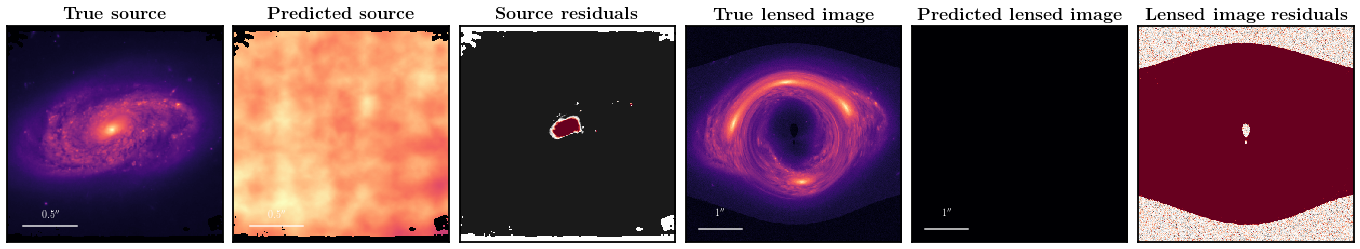

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

<Figure size 443.077x360 with 0 Axes>

In [58]:
from celluloid import Camera

epoch = -1

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 6, figsize=(19, 4.5))

camera = Camera(fig)

for i in range(len(hist["reconstructed_lens"])):

    source_coord_limit = 1.

    im_list = []

    im_list.append(ax[0].imshow(im_source * ~snr / std_noise * lens_sim.conversion_factor, cmap=cmap, vmin=0, extent=[*x_lims, *y_lims]))
    ax[0].set_xlim(-source_coord_limit, source_coord_limit)
    ax[0].set_ylim(-source_coord_limit, source_coord_limit)
    ax[0].set_title(r"\bf{True source}")

    im_list.append(ax[1].imshow((hist["reconstructed_src_mu"][i]) * ~snr / std_noise * lens_sim.conversion_factor, cmap=cmap, vmin=0, extent=[*x_lims, *y_lims]))
    ax[1].set_xlim(-source_coord_limit, source_coord_limit)
    ax[1].set_ylim(-source_coord_limit, source_coord_limit)
    ax[1].set_title(r"\bf{Predicted source}")

    im_list.append(ax[2].imshow((hist["reconstructed_src_mu"][i] - im_source) * ~snr * lens_sim.conversion_factor / std_noise, vmin=-4, vmax=4, cmap=cmap_resid, extent=[*x_lims, *y_lims]))
    ax[2].set_xlim(-source_coord_limit, source_coord_limit)
    ax[2].set_ylim(-source_coord_limit, source_coord_limit)
    ax[2].set_title(r"\bf{Source residuals}")

    im_list.append(ax[3].imshow(image_input[0].T / std_noise, cmap=cmap, extent=[*x_lims, *y_lims]))
    im_list.append(ax[4].imshow((hist["reconstructed_lens"][i]) / std_noise, cmap=cmap, extent=[*x_lims, *y_lims]))
    im_list.append(ax[5].imshow((hist["reconstructed_lens"][i] - image_input[0].T) / std_noise, cmap=cmap_resid, vmin=-4, vmax=4, extent=[*x_lims, *y_lims]))
    
    # ax[6].plot(np.arange(plot_every * (i)), np.array(hist["train_loss"][:plot_every * (i)]) / (n_xy * n_xy), color=cols_default[0])
    
    ax[3].set_title(r"\bf{True lensed image}")
    ax[4].set_title(r"\bf{Predicted lensed image}")
    ax[5].set_title(r"\bf{Lensed image residuals}")
    # ax[6].set_title(r"\bf{Loss}")

    for i_lens in [3, 4]:
        ax[i_lens].plot([-2.2, -1.2], [-2.2, -2.2], c="white", lw=1.5, ls="-")
        ax[i_lens].text(-1.7, -1.85, "$1''$", va="center", ha="center", color="white")

    for i_src in [0, 1]:
        ax[i_src].plot([-0.85, -0.35], [-0.85, -0.85], c="white", lw=1.5, ls="-")
        ax[i_src].text(-0.6, -0.75, "$0.5''$", va="center", ha="center", color="white")

    # labels = ["Image / noise", "Mean / noise", "(Mean - true) / noise", "Image / noise", "Mean / noise", "(Mean - true) / noise"]
    # for j in range(6):
    #     divider = make_axes_locatable(ax[j])
    #     cax = divider.append_axes('bottom', size='5%', pad=0.2)
    #     cbar = fig.colorbar(im_list[j], cax=cax, orientation="horizontal", label=labels[j])


    # labels = [r'\emph{(a)}',r'\emph{(b)}',r'\emph{(c)}',r'\emph{(d)}',r'\emph{(e)}',r'\emph{(f)}']
    # colors = ['w','w','k','w','w','k']
    # for i in range(6):
    #     ax[i].text(0.1, 0.9, labels[i], 
    #          horizontalalignment='center',
    #          verticalalignment='center',
    #          transform = ax[i].transAxes,
    #          color=colors[i], fontsize=17)

    [axx.xaxis.set_visible(False) for axx in ax.flatten()];
    [axx.yaxis.set_visible(False) for axx in ax.flatten()];
    plt.tight_layout();
    plt.show()
    camera.snap()

In [59]:
animation = camera.animate()
animation.save('figures/render.gif', fps=10)

## Paper Figure 1

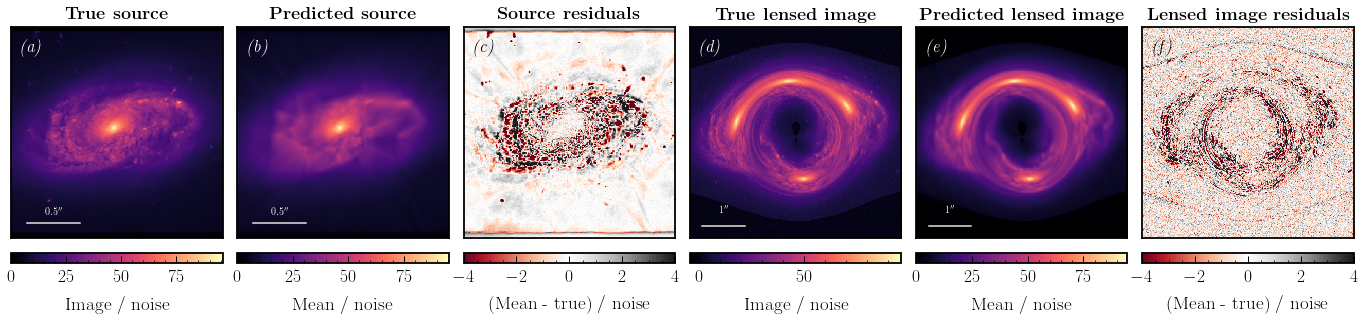

In [123]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 6, figsize=(19, 4.5))

i = -1

source_coord_limit = 1.

im_list = []

im_list.append(ax[0].imshow(im_source / std_noise * lens_sim.conversion_factor, cmap=cmap, vmin=0, extent=[*x_lims, *y_lims]))
ax[0].set_xlim(-source_coord_limit, source_coord_limit)
ax[0].set_ylim(-source_coord_limit, source_coord_limit)
ax[0].set_title(r"\bf{True source}")

im_list.append(ax[1].imshow((hist["reconstructed_src_mu"][i]) / std_noise * lens_sim.conversion_factor, cmap=cmap, vmin=0, extent=[*x_lims, *y_lims]))
ax[1].set_xlim(-source_coord_limit, source_coord_limit)
ax[1].set_ylim(-source_coord_limit, source_coord_limit)
ax[1].set_title(r"\bf{Predicted source}")

im_list.append(ax[2].imshow((hist["reconstructed_src_mu"][i] - im_source) * lens_sim.conversion_factor / std_noise, vmin=-4, vmax=4, cmap=cmap_resid, extent=[*x_lims, *y_lims]))
ax[2].set_xlim(-source_coord_limit, source_coord_limit)
ax[2].set_ylim(-source_coord_limit, source_coord_limit)
ax[2].set_title(r"\bf{Source residuals}")

im_list.append(ax[3].imshow(image_input[0].T / std_noise, cmap=cmap, extent=[*x_lims, *y_lims]))
im_list.append(ax[4].imshow((hist["reconstructed_lens"][i]) / std_noise, cmap=cmap, extent=[*x_lims, *y_lims]))
im_list.append(ax[5].imshow((hist["reconstructed_lens"][i] - image_input[0].T) / std_noise, cmap=cmap_resid, vmin=-4, vmax=4, extent=[*x_lims, *y_lims]))

ax[3].set_title(r"\bf{True lensed image}")
ax[4].set_title(r"\bf{Predicted lensed image}")
ax[5].set_title(r"\bf{Lensed image residuals}")

for i_lens in [3, 4]:
    ax[i_lens].plot([-2.2, -1.2], [-2.2, -2.2], c="white", lw=1.5, ls="-")
    ax[i_lens].text(-1.7, -1.85, "$1''$", va="center", ha="center", color="white")

for i_src in [0, 1]:
    ax[i_src].plot([-0.85, -0.35], [-0.85, -0.85], c="white", lw=1.5, ls="-")
    ax[i_src].text(-0.6, -0.75, "$0.5''$", va="center", ha="center", color="white")

labels = ["Image / noise", "Mean / noise", "(Mean - true) / noise", "Image / noise", "Mean / noise", "(Mean - true) / noise"]
for i in range(6):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('bottom', size='5%', pad=0.2)
    cbar = fig.colorbar(im_list[i], cax=cax, orientation="horizontal", label=labels[i])


labels = [r'\emph{(a)}',r'\emph{(b)}',r'\emph{(c)}',r'\emph{(d)}',r'\emph{(e)}',r'\emph{(f)}']
colors = ['w','w','k','w','w','k']
for i in range(6):
    ax[i].text(0.1, 0.9, labels[i], 
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax[i].transAxes,
         color=colors[i], fontsize=17)

[axx.xaxis.set_visible(False) for axx in ax.flatten()];
[axx.yaxis.set_visible(False) for axx in ax.flatten()];

plt.tight_layout()
# plt.savefig("figures/reconstruction.pdf")

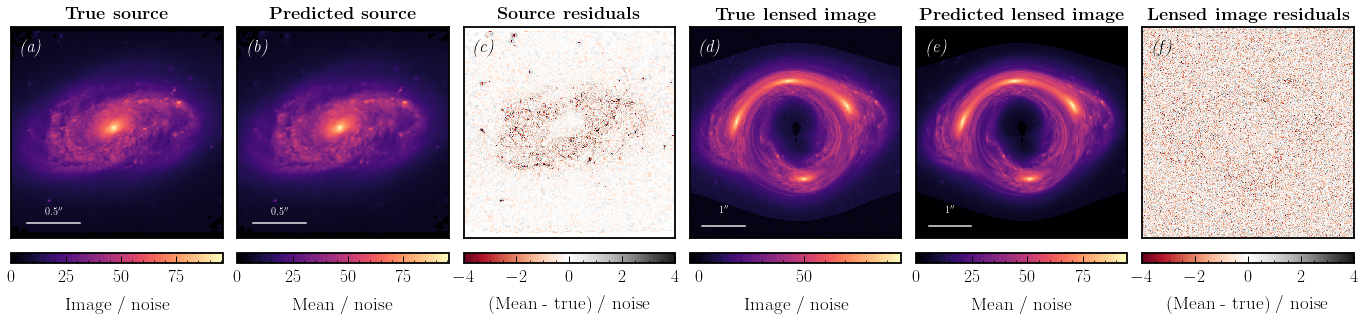

In [115]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 6, figsize=(19, 4.5))

i = -1

source_coord_limit = 1.

im_list = []

im_list.append(ax[0].imshow(im_source * ~snr / std_noise * lens_sim.conversion_factor, cmap=cmap, vmin=0, extent=[*x_lims, *y_lims]))
ax[0].set_xlim(-source_coord_limit, source_coord_limit)
ax[0].set_ylim(-source_coord_limit, source_coord_limit)
ax[0].set_title(r"\bf{True source}")

im_list.append(ax[1].imshow((hist["reconstructed_src_mu"][i]) * ~snr / std_noise * lens_sim.conversion_factor, cmap=cmap, vmin=0, extent=[*x_lims, *y_lims]))
ax[1].set_xlim(-source_coord_limit, source_coord_limit)
ax[1].set_ylim(-source_coord_limit, source_coord_limit)
ax[1].set_title(r"\bf{Predicted source}")

im_list.append(ax[2].imshow((hist["reconstructed_src_mu"][i] - im_source) * ~snr * lens_sim.conversion_factor / std_noise, vmin=-4, vmax=4, cmap=cmap_resid, extent=[*x_lims, *y_lims]))
ax[2].set_xlim(-source_coord_limit, source_coord_limit)
ax[2].set_ylim(-source_coord_limit, source_coord_limit)
ax[2].set_title(r"\bf{Source residuals}")

im_list.append(ax[3].imshow(image_input[0].T / std_noise, cmap=cmap, extent=[*x_lims, *y_lims]))
im_list.append(ax[4].imshow((hist["reconstructed_lens"][i]) / std_noise, cmap=cmap, extent=[*x_lims, *y_lims]))
im_list.append(ax[5].imshow((hist["reconstructed_lens"][i] - image_input[0].T) / std_noise, cmap=cmap_resid, vmin=-4, vmax=4, extent=[*x_lims, *y_lims]))

ax[3].set_title(r"\bf{True lensed image}")
ax[4].set_title(r"\bf{Predicted lensed image}")
ax[5].set_title(r"\bf{Lensed image residuals}")

for i_lens in [3, 4]:
    ax[i_lens].plot([-2.2, -1.2], [-2.2, -2.2], c="white", lw=1.5, ls="-")
    ax[i_lens].text(-1.7, -1.85, "$1''$", va="center", ha="center", color="white")

for i_src in [0, 1]:
    ax[i_src].plot([-0.85, -0.35], [-0.85, -0.85], c="white", lw=1.5, ls="-")
    ax[i_src].text(-0.6, -0.75, "$0.5''$", va="center", ha="center", color="white")

labels = ["Image / noise", "Mean / noise", "(Mean - true) / noise", "Image / noise", "Mean / noise", "(Mean - true) / noise"]
for i in range(6):
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('bottom', size='5%', pad=0.2)
    cbar = fig.colorbar(im_list[i], cax=cax, orientation="horizontal", label=labels[i])


labels = [r'\emph{(a)}',r'\emph{(b)}',r'\emph{(c)}',r'\emph{(d)}',r'\emph{(e)}',r'\emph{(f)}']
colors = ['w','w','k','w','w','k']
for i in range(6):
    ax[i].text(0.1, 0.9, labels[i], 
         horizontalalignment='center',
         verticalalignment='center',
         transform = ax[i].transAxes,
         color=colors[i], fontsize=17)

[axx.xaxis.set_visible(False) for axx in ax.flatten()];
[axx.yaxis.set_visible(False) for axx in ax.flatten()];

plt.tight_layout()
# plt.savefig("figures/reconstruction.pdf")

## Save plotting data

In [218]:
i = -1

In [123]:
# Save figure data
np.savez("../data/fig1_data.npz",
         reconstructed_lens=hist["reconstructed_lens"][i], 
         reconstructed_src_mu=hist["reconstructed_src_mu"][i],
         snr=snr,
         im_source=im_source,
         image_input=image_input[0])

In [125]:
# Save figure data

i = -1
np.savez("../data/fig1_data_no_pos.npz",
         reconstructed_lens=hist["reconstructed_lens"][i], 
         reconstructed_src_mu=hist["reconstructed_src_mu"][i],
         snr=snr,
         im_source=im_source,
         image_input=image_input[0])

In [54]:
# Save figure data

i = -1
np.savez("../data/fig1_data_rff.npz",
         reconstructed_lens=hist["reconstructed_lens"][i], 
         reconstructed_src_mu=hist["reconstructed_src_mu"][i],
         snr=snr,
         im_source=im_source,
         image_input=image_input[0])

In [171]:
# Save figure data
# Made with lens config 1

i = -1
np.savez("../data/fig1_data_ngc1300.npz",
         reconstructed_lens=hist["reconstructed_lens"][i], 
         reconstructed_src_mu=hist["reconstructed_src_mu"][i],
         snr=snr,
         im_source=im_source,
         image_input=image_input[0])

In [216]:
# Save figure data
# Made with lens config 0

i = -1
np.savez("../data/fig1_data_ugc6093.npz",
         reconstructed_lens=hist["reconstructed_lens"][i], 
         reconstructed_src_mu=hist["reconstructed_src_mu"][i],
         snr=snr,
         im_source=im_source,
         image_input=image_input[0])

## Exploring variations

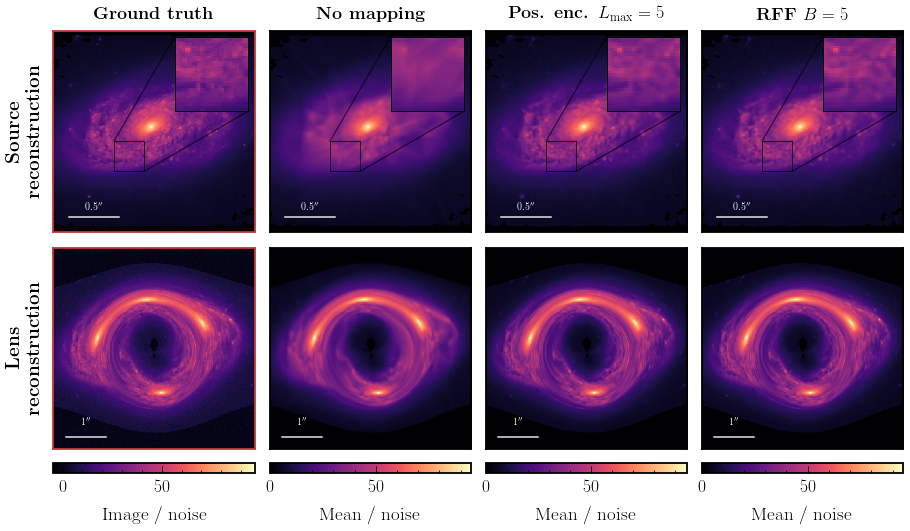

In [256]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(2, 4, figsize=(9.8 * 1.3, 5.8 * 1.3))

source_coord_limit = 1.
snr = np.load("../data/fig1_data_rff.npz")['snr']

im_list_src = []
im_list_lens = []
labels = ['_no_pos', '', '_rff']
titles = ["No mapping", "Pos. enc. $L_\mathrm{max} = 5$", "RFF $B = 5$"]

im_list_src.append(ax[0, 0].imshow(np.load("../data/fig1_data{}.npz".format(labels[i_src - 1]))['im_source'] * ~snr / std_noise * lens_sim.conversion_factor, cmap=cmap, vmin=0, extent=[*x_lims, *y_lims]))
ax[0,0].set_xlim(-source_coord_limit, source_coord_limit)
ax[0,0].set_ylim(-source_coord_limit, source_coord_limit)
ax[0,0].set_title(r"\bf{Ground truth}", y=1.02)

im_list_lens.append(ax[1,0].imshow(np.load("../data/fig1_data{}.npz".format(labels[i_src - 1]))['image_input'].T / std_noise, cmap=cmap, extent=[*x_lims, *y_lims]))
# ax[1,0].set_title(r"\bf{Ground truth}")

for i in range(1, 4):
    im_list_src.append(ax[0,i].imshow(np.load("../data/fig1_data{}.npz".format(labels[i - 1]))['reconstructed_src_mu'] * ~snr / std_noise * lens_sim.conversion_factor, cmap=cmap, vmin=0, extent=[*x_lims, *y_lims]))
    ax[0,i].set_xlim(-source_coord_limit, source_coord_limit)
    ax[0,i].set_ylim(-source_coord_limit, source_coord_limit)
    ax[0,i].set_title(r"\bf{{{}}}".format(titles[i - 1]), y=1.02)
    
for i in range(1, 4):
    im_list_lens.append(ax[1,i].imshow(np.load("../data/fig1_data{}.npz".format(labels[i - 1]))['reconstructed_lens'] / std_noise, cmap=cmap, vmin=0, extent=[*x_lims, *y_lims]))
    # ax[1,i].set_title(r"\bf{{{}}}".format(titles[i - 1]))

for i_lens in range(4):
    ax[1, i_lens].plot([-2.2, -1.2], [-2.2, -2.2], c="white", lw=1.5, ls="-")
    ax[1, i_lens].text(-1.7, -1.85, "$1''$", va="center", ha="center", color="white")

for i_src in range(4):
    ax[0, i_src].plot([-0.85, -0.35], [-0.85, -0.85], c="white", lw=1.5, ls="-")
    ax[0, i_src].text(-0.6, -0.75, "$0.5''$", va="center", ha="center", color="white")
            
    # Inset
    axins = ax[0, i_src].inset_axes([0.6, 0.6, 0.37, 0.37])
    
    if i_src == 0:
        axins.imshow(np.load("../data/fig1_data{}.npz".format(labels[i_src - 1]))['im_source'] * ~snr / std_noise * lens_sim.conversion_factor, extent=[*x_lims, *y_lims], cmap=cmap, vmin=0)
    else:
        axins.imshow(np.load("../data/fig1_data{}.npz".format(labels[i_src - 1]))['reconstructed_src_mu'] * ~snr / std_noise * lens_sim.conversion_factor, extent=[*x_lims, *y_lims], cmap=cmap, vmin=0)

    x1, x2, y1, y2 = -0.4, -0.1, -0.4, -0.1
    axins.set_xlim(x1, x2)
    axins.set_ylim(y1, y2)
    axins.set_xticklabels([])
    axins.set_yticklabels([])

    axins.xaxis.set_visible(False)
    axins.yaxis.set_visible(False)

    for side in ['bottom', 'top', 'right', 'left']:
        axins.spines[side].set_color('k')

    ax[0, i_src].indicate_inset_zoom(axins, edgecolor="k", alpha=0.75)
    [x.set_linewidth(1.) for x in axins.spines.values()]


labels = ["Image / noise", "Mean / noise", "Mean / noise", "Mean / noise"]
for i in range(4):
    for j in range(1, 2):
        divider = make_axes_locatable(ax[j, i])
        cax = divider.append_axes('bottom', size='5%', pad=0.2)
        if j == 0:
            cbar = fig.colorbar(im_list_src[i], cax=cax, orientation="horizontal", label=labels[i])
        else:
            cbar = fig.colorbar(im_list_lens[i], cax=cax, orientation="horizontal", label=labels[i])

[axx.xaxis.set_visible(False) for axx in ax.flatten()];
[axx.yaxis.set_visible(False) for axx in ax.flatten()];

for side in ['bottom', 'top', 'right', 'left']:
    ax[0,0].spines[side].set_color(cols_default[0])
    ax[1,0].spines[side].set_color(cols_default[0])

ax[0,0].yaxis.set_visible(True)
ax[1,0].yaxis.set_visible(True)
ax[0,0].yaxis.set_ticks([])
ax[1,0].yaxis.set_ticks([])

ax[0,0].set_ylabel(r'\bf{Source}' + '\n' + r'\bf{reconstruction}')
ax[1,0].set_ylabel(r'\bf{Lens}' + '\n' + r'\bf{reconstruction}')

plt.tight_layout()
plt.savefig("figures/variations.pdf")

## Other sources

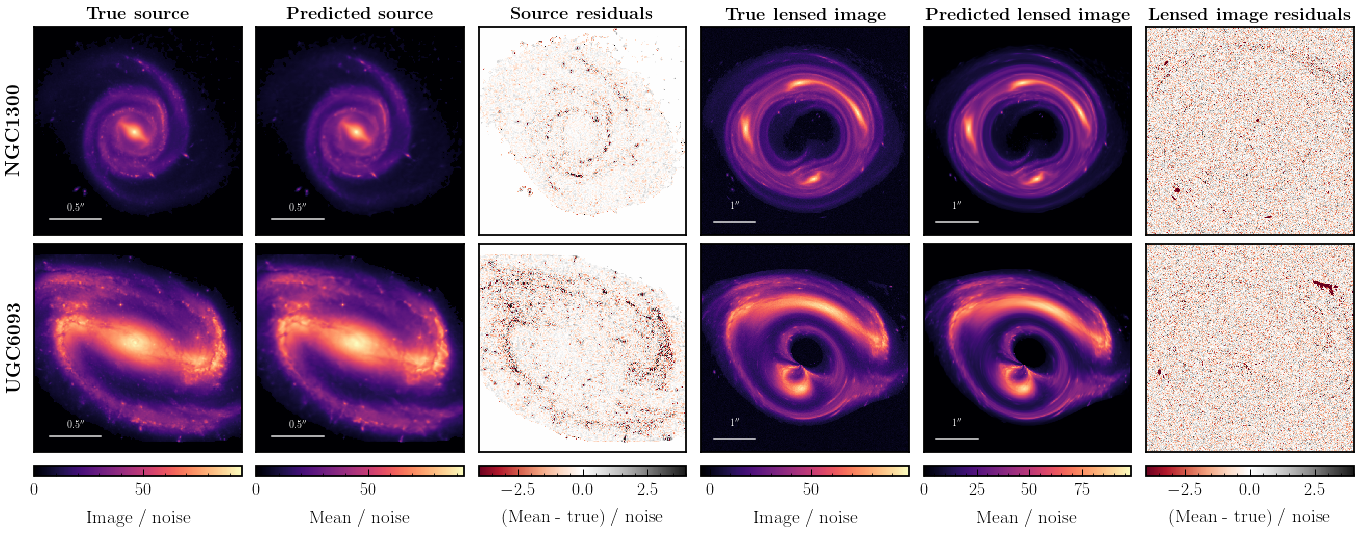

In [249]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(2, 6, figsize=(19, 7.5))

i = -1

source_coord_limit = 1.

im_list = []

for ii in range(2):
    
    if ii == 0:
        file = np.load("../data/fig1_data_ugc6093.npz")
        vmax_lens = file["reconstructed_lens"].max() / std_noise
    elif ii == 1:
        file = np.load("../data/fig1_data_ngc1300.npz")

    snr = file['snr']
    
    im_list.append(ax[ii, 0].imshow(file['im_source'] * ~snr / std_noise * lens_sim.conversion_factor, cmap=cmap, vmin=0, extent=[*x_lims, *y_lims]))
    ax[ii, 0].set_xlim(-source_coord_limit, source_coord_limit)
    ax[ii, 0].set_ylim(-source_coord_limit, source_coord_limit)
    

    im_list.append(ax[ii, 1].imshow((file["reconstructed_src_mu"]) * ~snr / std_noise * lens_sim.conversion_factor, cmap=cmap, vmin=0, extent=[*x_lims, *y_lims]))
    ax[ii, 1].set_xlim(-source_coord_limit, source_coord_limit)
    ax[ii, 1].set_ylim(-source_coord_limit, source_coord_limit)
    

    im_list.append(ax[ii, 2].imshow((file["reconstructed_src_mu"] - file['im_source']) * ~snr * lens_sim.conversion_factor / std_noise, vmin=-4, vmax=4, cmap=cmap_resid, extent=[*x_lims, *y_lims]))
    ax[ii, 2].set_xlim(-source_coord_limit, source_coord_limit)
    ax[ii, 2].set_ylim(-source_coord_limit, source_coord_limit)
    

    im_list.append(ax[ii, 3].imshow(file['image_input'].T / std_noise, cmap=cmap, extent=[*x_lims, *y_lims], vmax=vmax_lens))
    im_list.append(ax[ii, 4].imshow((file["reconstructed_lens"]) / std_noise, cmap=cmap, extent=[*x_lims, *y_lims], vmax=vmax_lens))
    im_list.append(ax[ii, 5].imshow((file["reconstructed_lens"] - file['image_input'].T) / std_noise, cmap=cmap_resid, vmin=-4, vmax=4, extent=[*x_lims, *y_lims]))
    
    if ii == 0:
        ax[ii, 0].set_title(r"\bf{True source}")
        ax[ii, 1].set_title(r"\bf{Predicted source}")
        ax[ii, 2].set_title(r"\bf{Source residuals}")
        ax[ii, 3].set_title(r"\bf{True lensed image}")
        ax[ii, 4].set_title(r"\bf{Predicted lensed image}")
        ax[ii, 5].set_title(r"\bf{Lensed image residuals}")

    for i_lens in [3, 4]:
        ax[ii, i_lens].plot([-2.2, -1.2], [-2.2, -2.2], c="white", lw=1.5, ls="-")
        ax[ii, i_lens].text(-1.7, -1.85, "$1''$", va="center", ha="center", color="white")

    for i_src in [0, 1]:
        ax[ii, i_src].plot([-0.85, -0.35], [-0.85, -0.85], c="white", lw=1.5, ls="-")
        ax[ii, i_src].text(-0.6, -0.75, "$0.5''$", va="center", ha="center", color="white")

    labels = ["Image / noise", "Mean / noise", "(Mean - true) / noise", "Image / noise", "Mean / noise", "(Mean - true) / noise"]
    
    if ii == 1:
        for i in range(6, 12):
            divider = make_axes_locatable(ax[ii, i - 6])
            cax = divider.append_axes('bottom', size='5%', pad=0.2)
            cbar = fig.colorbar(im_list[i], cax=cax, orientation="horizontal", label=labels[i - 6])


# labels = [r'\emph{(a)}',r'\emph{(b)}',r'\emph{(c)}',r'\emph{(d)}',r'\emph{(e)}',r'\emph{(f)}']
# colors = ['w','w','k','w','w','k']
# for i in range(6):
#     ax[i].text(0.1, 0.9, labels[i], 
#          horizontalalignment='center',
#          verticalalignment='center',
#          transform = ax[i].transAxes,
#          color=colors[i], fontsize=17)

[axx.xaxis.set_visible(False) for axx in ax.flatten()];
[axx.yaxis.set_visible(False) for axx in ax.flatten()];

ax[0,0].yaxis.set_visible(True)
ax[1,0].yaxis.set_visible(True)
ax[0,0].yaxis.set_ticks([])
ax[1,0].yaxis.set_ticks([])

ax[0,0].set_ylabel(r'\bf{NGC1300}')
ax[1,0].set_ylabel(r'\bf{UGC6093}')

plt.tight_layout()
plt.savefig("figures/reconstruction_sources.pdf")